In [ ]:
%matplotlib inline  
from fastai.vision import *
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from efficientnet_pytorch import EfficientNet
import pretrainedmodels

In [ ]:
def load_val(name ='val_idx_pi.joblib', PATH_=Path('../VAL_by_Patience')):  
    return load(PATH_/name)

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)


def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float, SUFFIX = 'PHASE_1_COS'):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
             TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}'))
    learn.fit(n_epochs)

In [ ]:
PATH = Path('..')
BS =            512
SZ =            224
FOLD =0
EXP_NAME =      f'NB_EXP_300_CV_{FOLD}_{SZ}'
IMG_TRAIN_224 = PATH/'train_images__3chn_bg_224'
IMG_TEST_224  = PATH/'test_images__3chn_bg_224'
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_SUBMI =      pd.read_csv(PATH/'stage_1_sample_submission.csv')



DF_SUBMI['fn'] = DF_SUBMI.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
DF_TRAIN['labels'].fillna('', inplace=True)
VAL_IDX = load_val()

In [8]:
ItemList.label_from_df = modified_label_from_df
test_fns = DF_SUBMI.fn.unique()
tfms = get_transforms(max_rotate=360,
                      flip_vert=True,
                      max_zoom=1.4, 
                      max_lighting=0.3, 
                      xtra_tfms=cutout(n_holes=(15, 50), length=(8, 40), p=0.7))

data = (ImageList.from_csv('..', 'train_labels_as_strings.csv', folder=IMG_TRAIN_224.name)
        .split_by_idxs(valid_idx=VAL_IDX[0], train_idx=VAL_IDX[1])
        .label_from_df(label_delim=' ')
        .transform(tfms = tfms,size=SZ)
        .add_test('../' +IMG_TEST_224.name + '/' + test_fns)
        .databunch(bs=BS)
        .normalize(imagenet_stats))

        

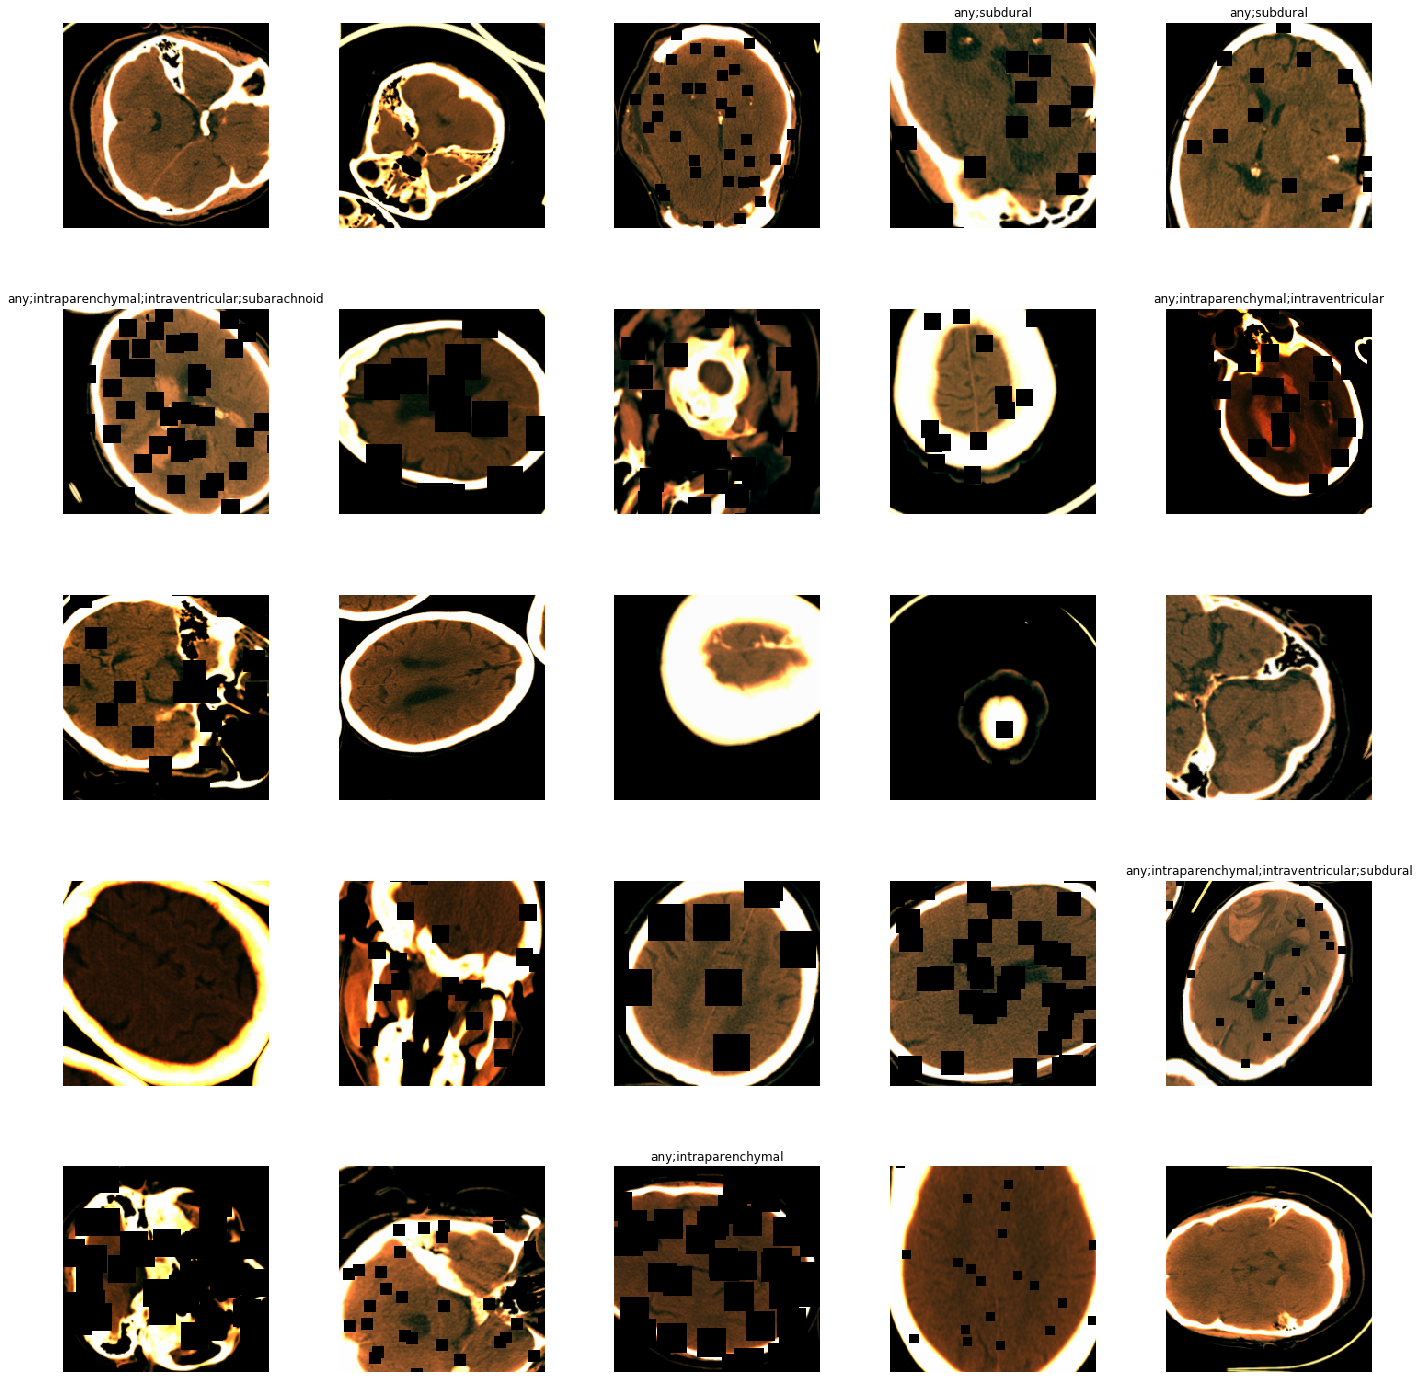

In [9]:
data.show_batch()

In [10]:
weights = np.array([2.0, 1.0, 1.0, 1.0, 1.0, 1.0])
weights

array([2., 1., 1., 1., 1., 1.])

In [11]:
def my_loss(y_pred,y_true,weights = torch.FloatTensor(weights).cuda()):
    return F.binary_cross_entropy_with_logits(y_pred,
                                  y_true,
                                  weights.repeat(y_pred.shape[0],1))

md_ef =  EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.c)
learn = Learner(data,
                md_ef,
                wd=1e-2,
                bn_wd=False, 
                true_wd=True, 
                metrics=[accuracy_thresh])

learn.loss_func  = my_loss
learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.unfreeze()
learn.lr_find()

Loaded pretrained weights for efficientnet-b0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


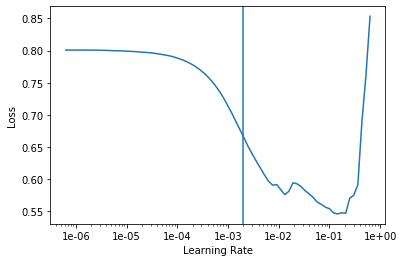

In [12]:
lr = 0.002
learn.recorder.plot()
plt.axvline(lr)

In [ ]:
learn.unfreeze()
SUFFIX = 'UNFRZ'
learn.fit_one_cycle(50,
                    lr, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}')])

epoch,train_loss,valid_loss,accuracy_thresh,time


In [ ]:
#if using custom loss need to take sigmoid 
def get_preds(learn:Learner, sub_fn: str=f'{EXP_NAME}_PHASE_2_COS', TTA: bool = False, dt_type = DatasetType.Test):
    if TTA:
        learn.to_fp32()
        preds, targs = learn.TTA(ds_type=dt_type)
        sub_fn = f'{sub_fn}_TTA'

    else:
        preds, targs = learn.get_preds(dt_type)
        
    ids = []
    labels = []
    preds = torch.sigmoid(preds)
    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)
    pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'{sub_fn}.csv', index=False)

In [ ]:
get_preds(learn)

In [ ]:
get_preds(learn, TTA=True)

In [ ]:
!sudo shutdown 